# Analisis de incertidumbre

Notebook para analizar algoritmos cuando se tiene incertidumbre en el tiempo de partida.

En primer lugar definimos el algoritmo a estudiar (por ahora EDF o LLF)

In [1]:
Algorithm = "EDF";

In [26]:
using Pkg;Pkg.instantiate()
import Pkg; Pkg.add("DataFrames"); Pkg.add("CSV")
using EVQueues, Plots, Distributions

  Resolving package versions...
Updating `C:\Users\lucas\Documents\GitHub\ev_notebooks\Project.toml`
  [a93c6f00] + DataFrames v0.22.5
No Changes to `C:\Users\lucas\Documents\GitHub\ev_notebooks\Manifest.toml`


Se definen los parámetros para realizar las simulaciones

In [57]:
#Desviación standard de la incertidumbre (se modela como una Gaussiana)
sigma=0.2

#Parámetros del resto de la simulación
lambda=60.0;
mu=1;
gamma=1;
C=40.0;
Tfinal=1.0;

#Se agrega snaps para hacer animaciones
snaps = collect(0.1:.5:100.0);

#df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

using DataFrames, CSV
df=CSV.read("C:\\Users\\lucas\\Documents\\GitHub\\ev_notebooks\\df.csv", DataFrame);
df.arribos=df.arribos*1.0;
df.salidas=df.salidas*1.0;
df.potencias=df.potencias*1.0;

#df = generate_Poisson_stream(lambda,mu,gamma,Tfinal)

65×4 DataFrame
 Row │ arribos     demandas    salidas   potencias 
     │ Float64     Float64     Float64   Float64   
─────┼─────────────────────────────────────────────
   1 │ 0.00136669  0.171372    0.264074        1.0
   2 │ 0.0233207   0.0491931   0.771758        1.0
   3 │ 0.0399076   0.45984     1.12848         1.0
   4 │ 0.0658164   0.0309282   0.802847        1.0
   5 │ 0.102826    0.00181882  1.14309         1.0
   6 │ 0.105817    0.897161    1.0289          1.0
   7 │ 0.114392    0.253419    2.07621         1.0
   8 │ 0.117929    1.43792     4.14979         1.0
   9 │ 0.129379    0.605327    2.76762         1.0
  10 │ 0.138113    1.82629     3.80666         1.0
  11 │ 0.148292    1.53033     1.77475         1.0
  ⋮  │     ⋮           ⋮          ⋮          ⋮
  56 │ 0.779508    0.145734    1.52124         1.0
  57 │ 0.805149    0.199848    1.10156         1.0
  58 │ 0.821107    0.089697    1.17106         1.0
  59 │ 0.831443    0.421484    5.69165         1.0
  60 │ 0.911605    0.04403     1.681           1.0
  61 │ 0.941616    0.758207    1.96269         1.0
  62 │ 0.954       1.60394     2.60561         1.0
  63 │ 0.955123    0.173981    3.06985         1.0
  64 │ 0.969403    0.938495    2.67341         1.0
  65 │ 1.00806     3.75215     4.93904         1.0
                                    44 rows omitted

In [49]:
#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edfc_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

El siguiente cuadro analiza resultados de vehiculos individualmente

In [50]:
#df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edfc_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
perturbation = Normal(0,sigma)
reportedDeadlines = [d+rand(perturbation) for d in df[!,:salidas]]
df[!,:salidaReportada] = reportedDeadlines

if Algorithm == "EDF"
    alg_uncertain = ev_edfc_trace(df,C,snapshots=snaps);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df,C,snapshots=snaps);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

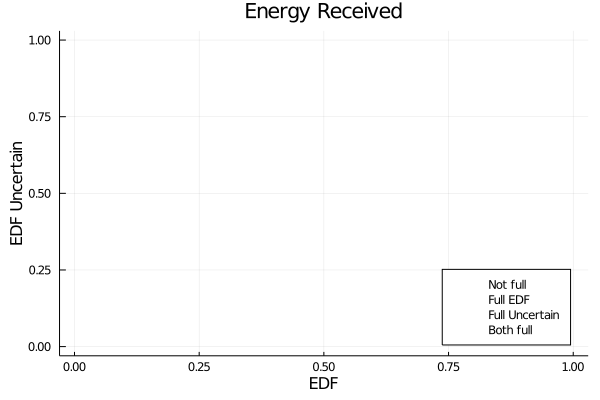

In [52]:
full_alg = [ev.departureWorkload==0 for ev in alg_evs];
full_alg_uncertain = [ev.departureWorkload==0 for ev in alg_uncertain_evs];
a=full_alg.*full_alg_uncertain
b=full_alg.+full_alg_uncertain
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel=Algorithm,
            ylabel=Algorithm * " Uncertain",
            title="Energy Received", legend=:bottomright)

scatter!(p,Sa_alg[both_unfull.==true],Sa_alg_uncertain[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_alg[full_alg.==true],Sa_alg_uncertain[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full "* Algorithm)
scatter!(p,Sa_alg[full_alg_uncertain.==true],Sa_alg_uncertain[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Uncertain")
scatter!(p,Sa_alg[both_full.==true],Sa_alg_uncertain[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

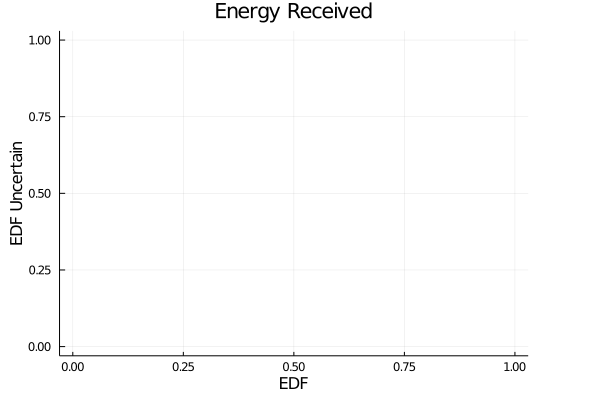

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [53]:
alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_departure-alg_uncertain_departure;

EV_overstayed = [i>0 for i in diff_departure]
EV_understayed = [i<0 for i in diff_departure]

p = plot(  xlabel=Algorithm,
            ylabel=Algorithm * " Uncertain",
            title="Energy Received", legend=:bottomright)

scatter!(p,Sa_alg[both_full.==false],Sa_alg_uncertain[both_full.==false],markershape=:circle,markersize=4,marker_z=(diff_departure[both_full.==false]),colorbar=true,label=false)

#scatter!(p,Sa_alg[EV_overstayed.==true],Sa_alg_uncertain[EV_overstayed.==true],markershape=:circle,markersize=4,color=:blue,label="EV Overstayed")
#scatter!(p,Sa_alg[EV_understayed.==true],Sa_alg_uncertain[EV_understayed.==true],markershape=:circle,markersize=4,color=:red,label="EV understayed")

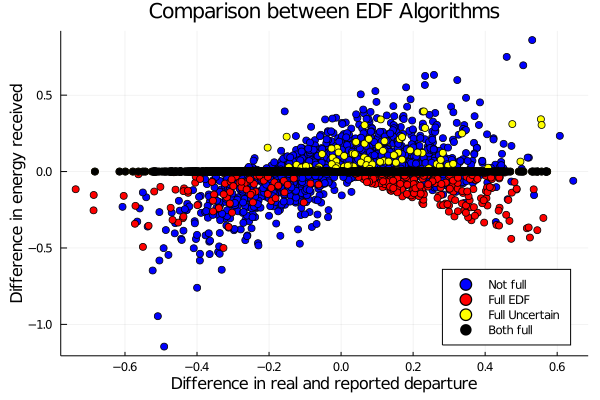

In [15]:
diff_Sa=Sa_alg_uncertain-Sa_alg;
alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_departure-alg_uncertain_departure;

p = plot(  xlabel="Difference in real and reported departure",
            ylabel="Difference in energy received",
            title="Comparison between " * Algorithm * " Algorithms", legend=:bottomright)

scatter!(p,diff_departure[both_unfull.==true],diff_Sa[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,diff_departure[full_alg.==true],diff_Sa[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full EDF")
scatter!(p,diff_departure[full_alg_uncertain.==true],diff_Sa[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Uncertain")
scatter!(p,diff_departure[both_full.==true],diff_Sa[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

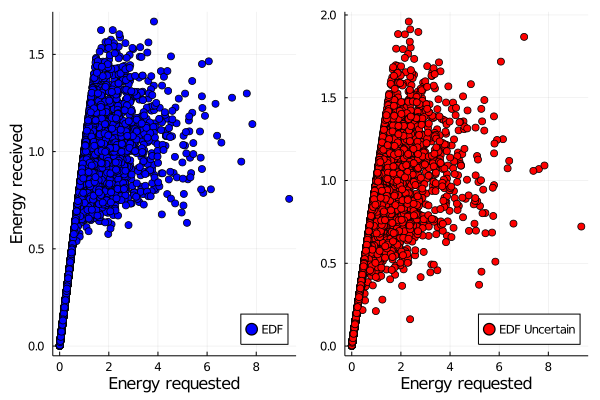

In [18]:
s1 = scatter(S_alg,Sa_alg,label=Algorithm, ylabel="Energy received",markershape=:circle,markersize=4,color=:blue, legend=:bottomright)
s2 = scatter(S_alg_uncertain,Sa_alg_uncertain,label=Algorithm* " Uncertain",markershape=:circle,markersize=4,color=:red, legend=:bottomright)
plot(s1, s2, layout = (1, 2), xlabel="Energy requested")